In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense

In [ ]:
# Load the dataset from a CSV file
input_file = '/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv' 
df = pd.read_csv(input_file)

In [ ]:
num_rows_to_process = 5  #
df_subset = df.head(num_rows_to_process)

In [ ]:
# Load a pre-trained GPT-2 model and tokenizer
model_name = 'gpt2-medium'  
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

In [ ]:
def generate_text_with_model(transaction_info):
    prompt = (
        f"The customer performed a {transaction_info['type']} transaction "
        f"with an amount of {transaction_info['amount']}. "
        f"The customer's initial balance was {transaction_info['oldbalanceOrg']} "
        f"and after the transaction, it became {transaction_info['newbalanceOrig']}. "
        f"The recipient had an initial balance of {transaction_info['oldbalanceDest']} "
        f"and after the transaction, it increased to {transaction_info['newbalanceDest']}. "
    )
    

In [ ]:
def generate_text_with_model(transaction_info):
    prompt = (
        f"The customer performed a {transaction_info['type']} transaction "
        f"with an amount of {transaction_info['amount']}. "
        f"The customer's initial balance was {transaction_info['oldbalanceOrg']} "
        f"and after the transaction, it became {transaction_info['newbalanceOrig']}. "
        f"The recipient had an initial balance of {transaction_info['oldbalanceDest']} "
        f"and after the transaction, it increased to {transaction_info['newbalanceDest']}. "
        
    )

    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    
    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_length=150,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.8 
        )
    
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    return generated_text

In [25]:
df_subset['Textual Representation'] = df_subset.apply(generate_text_with_model, axis=1)
df_subset['Label'] = df_subset['isFraud'].apply(lambda x: "Fraudulent" if x == 1 else "Non-Fraudulent")

output_file = 'fraud_sentiment_analysis_with_labels.xlsx'
df_subset[['Textual Representation', 'Label']].to_excel(output_file, index=False)



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [ ]:
# Load the new dataset
output_file = 'fraud_sentiment_analysis_with_labels.xlsx'
df = pd.read_excel(output_file)

In [ ]:
# Text and labels
texts = df['Textual Representation'].values
labels = df['Label'].values

In [ ]:
label_to_int = {'Non-Fraudulent': 0, 'Fraudulent': 1}
labels_encoded = np.array([label_to_int[label] for label in labels])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels_encoded, test_size=0.2, random_state=42)

In [ ]:
max_words = 10000  
max_sequence_length = 100 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [ ]:
# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
# Pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [ ]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [17]:
model = Sequential()

model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))
model.add(SimpleRNN(64))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.build(input_shape=(None, 100)) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test_cat))



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,386 (2.47 MB)

 Trainable params: 648,386 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9656 - loss: 0.0880 - val_accuracy: 0.9880 - val_loss: 0.0797
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9934 - loss: 0.0422 - val_accuracy: 0.9880 - val_loss: 0.0732
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9934 - loss: 0.0401 - val_accuracy: 0.9880 - val_loss: 0.0663
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9943 - loss: 0.0375 - val_accuracy: 0.9880 - val_loss: 0.0672
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9947 - loss: 0.0276 - val_accuracy: 0.9880 - val_loss: 0.0675
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9913 - loss: 0.0311 - val_accuracy: 0.9850 - val_loss: 0.0653
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9974 - loss: 0.0089 - val_accuracy: 0.9850 - val_loss: 0.0615
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9970 - loss: 0.0128 - val_accu

In [18]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Accuracy: {accuracy:.2f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9908 - loss: 0.0469
Test Accuracy: 0.99


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


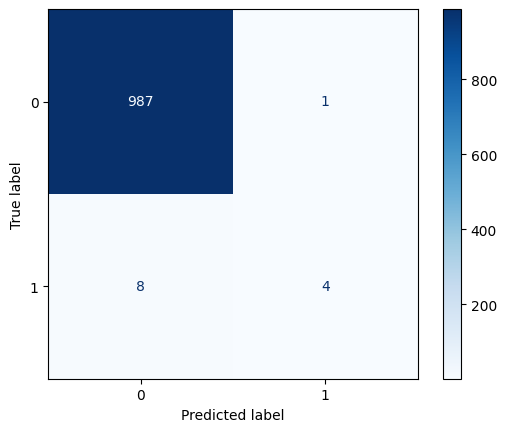

In [22]:
y_test_true = np.argmax(y_test_cat, axis=1)
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.show()


In [23]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test_true, y_pred_classes, target_names=['Class 0', 'Class 1'])

# Print the classification report
print(report)


              precision    recall  f1-score   support

     Class 0       0.99      1.00      1.00       988
     Class 1       0.80      0.33      0.47        12

    accuracy                           0.99      1000
   macro avg       0.90      0.67      0.73      1000
weighted avg       0.99      0.99      0.99      1000



In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

test_texts = ['''  The customer performed a PAYMENT transaction with an amount of 1864.28. 
The customer's initial balance was 21249.0 and after the transaction, it became 19384.72. 
The recipient had an initial balance of 0.0 and after the transaction, it increased to 0.0. ''']

sequences = tokenizer.texts_to_sequences(test_texts)
test_texts_pad = pad_sequences(sequences, maxlen=100)
predictions = model.predict(test_texts_pad)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = {0: 'Class 0', 1: 'Class 1'}  

# Print out predictions
for i, text in enumerate(test_texts):
    print(f"Text: {text}")
    print(f"Predicted Class: {class_labels[predicted_classes[i]]}")
    print(f"Prediction Confidence: {predictions[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Text:   The customer performed a PAYMENT transaction with an amount of 1864.28. 
The customer's initial balance was 21249.0 and after the transaction, it became 19384.72. 
The recipient had an initial balance of 0.0 and after the transaction, it increased to 0.0. 
Predicted Class: Class 0
Prediction Confidence: [9.999527e-01 4.733177e-05]
